# Rt Live Model

In [62]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fetch data and select the state's data

In [63]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [64]:
region = "OR"
model_data = df.loc[region]

In [65]:
model_data.tail(10)

,positive,total
date,,
2020-06-19,206.0,4781.0
2020-06-20,178.0,178.0
2020-06-21,187.0,8516.0
2020-06-22,146.0,4017.0
2020-06-23,191.0,4084.0
2020-06-24,170.0,3296.0
2020-06-25,124.0,2610.0
2020-06-26,0.0,0.0
2020-06-27,0.0,0.0


In [66]:
523/3

174.33333333333334

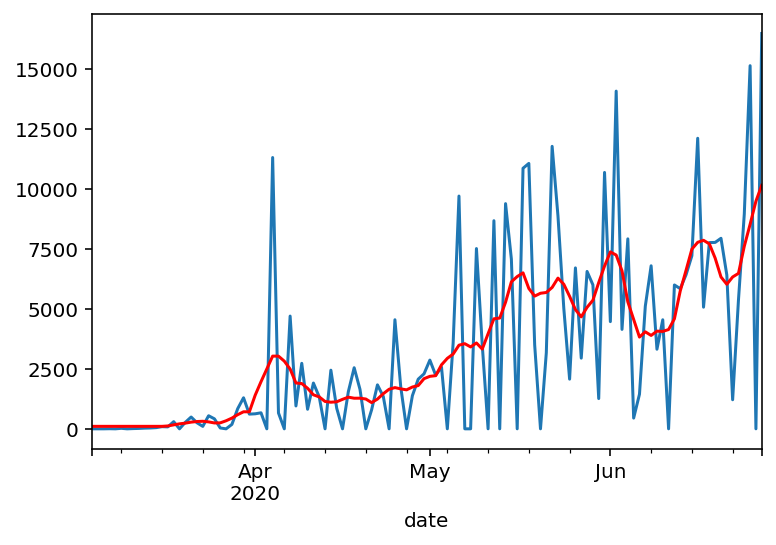

In [58]:
model_data.total.plot()
total = model_data.total.rolling(7, center=True, win_type="gaussian", min_periods=1).mean(std=2)
total = total.clip(pos.max()*.1)
total.plot(c="r")

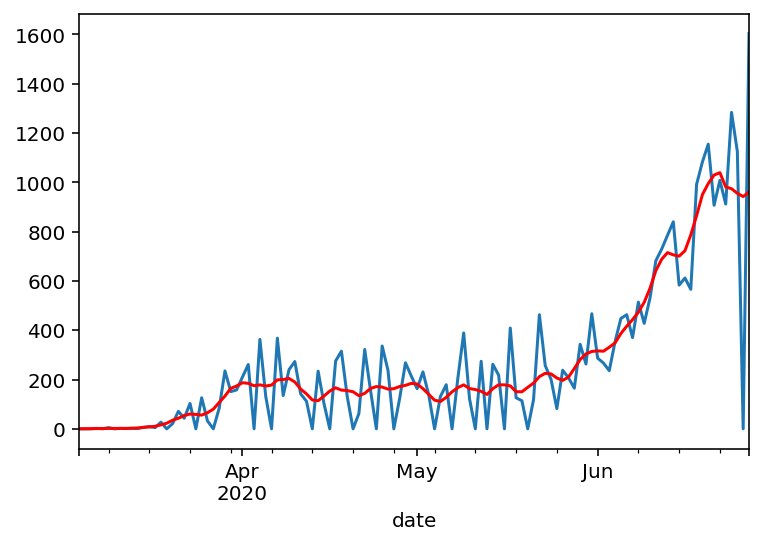

In [59]:
model_data.positive.plot()
pos = model_data.positive.rolling(7, center=True, win_type="gaussian", min_periods=1).mean(std=2)

pos.plot(c="r")

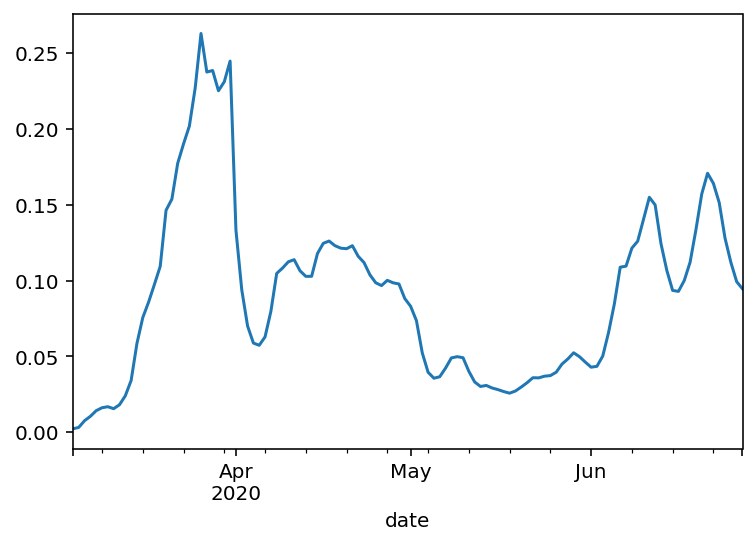

In [60]:
(pos/total).plot()

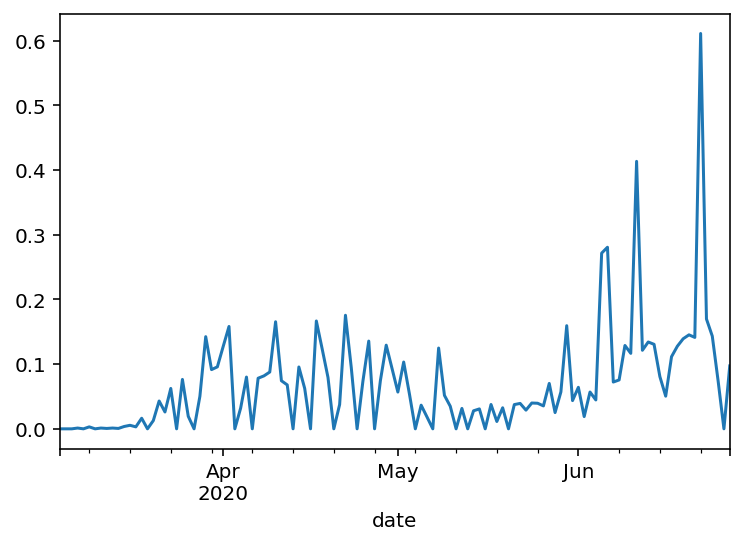

In [61]:
(model_data.positive/model_data.total.clip(model_data.total.max()*.1)).plot()

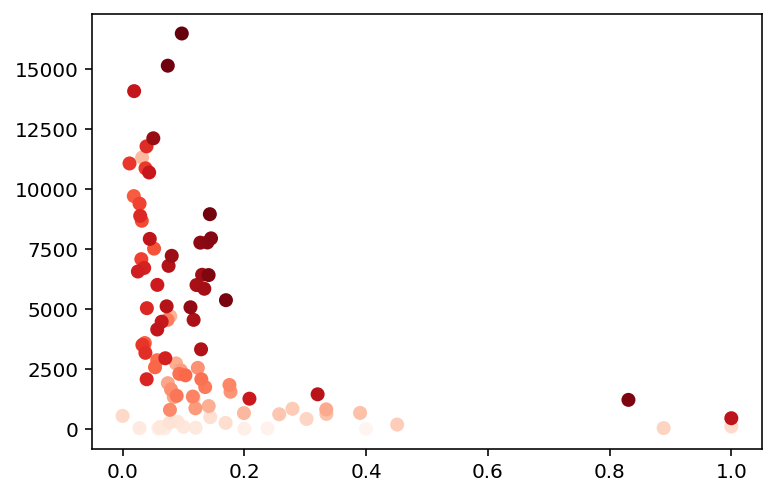

In [46]:
plt.scatter(
    (model_data.positive/model_data.total),
    model_data.total,
    c=np.arange(0, len(model_data)),
    cmap="Reds"
)

## Create the model instance and sample

In [33]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 447 seconds.


## Summarize Model Output

In [34]:
result = summarize_inference_data(gm.inference_data)

In [35]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-17,1.228454,1.219876,0.973497,1.394449,116.353497,90.354777,51.228661,120.0,4812.0
2020-06-18,1.228131,1.219014,0.993194,1.416937,121.702182,94.265623,63.525252,148.0,4786.0
2020-06-19,1.228767,1.217162,1.000023,1.455583,127.394099,98.350178,88.512754,206.0,4781.0
2020-06-20,1.231132,1.216502,0.967784,1.441709,133.462842,102.616679,429.379916,178.0,178.0
2020-06-21,1.231487,1.220808,1.003931,1.483511,139.944455,107.077059,45.109014,187.0,8516.0
2020-06-22,1.234833,1.224856,0.921344,1.418810,146.909691,111.746326,74.663510,146.0,4017.0
2020-06-23,1.233331,1.220845,0.911617,1.413843,154.401278,116.641923,96.073809,191.0,4084.0
2020-06-24,1.233270,1.215106,0.934973,1.451897,162.483556,121.783954,105.954424,170.0,3296.0
2020-06-25,1.233858,1.215870,0.951089,1.476506,171.175276,127.195896,97.597469,124.0,2610.0


## Plot Model Output

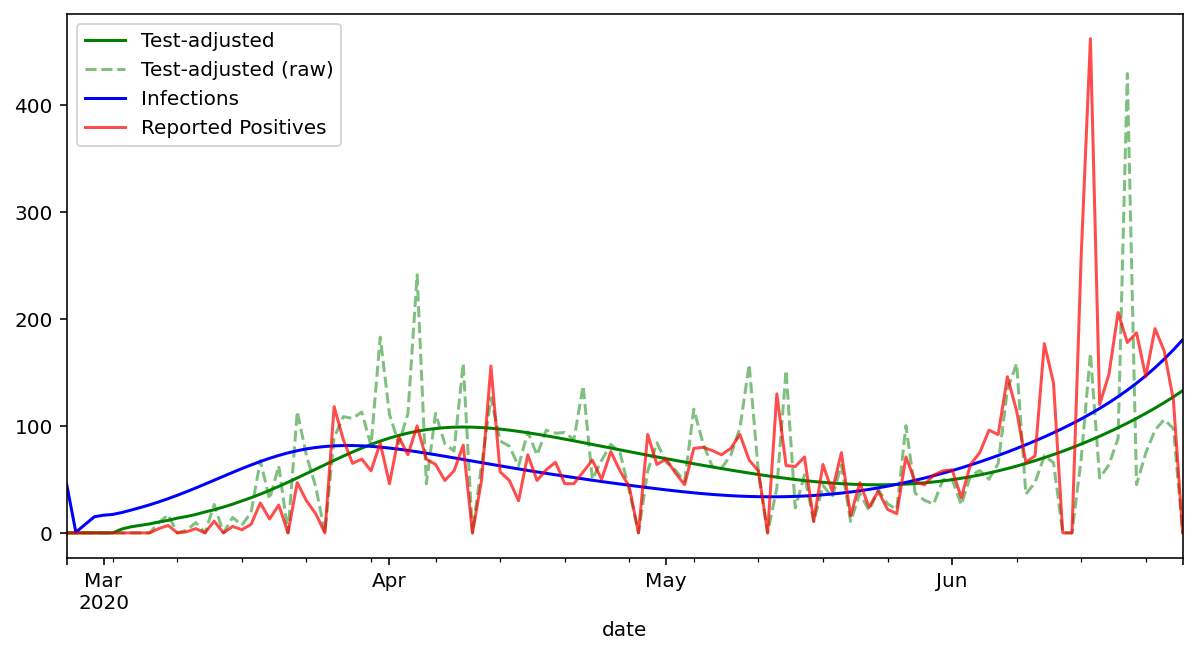

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

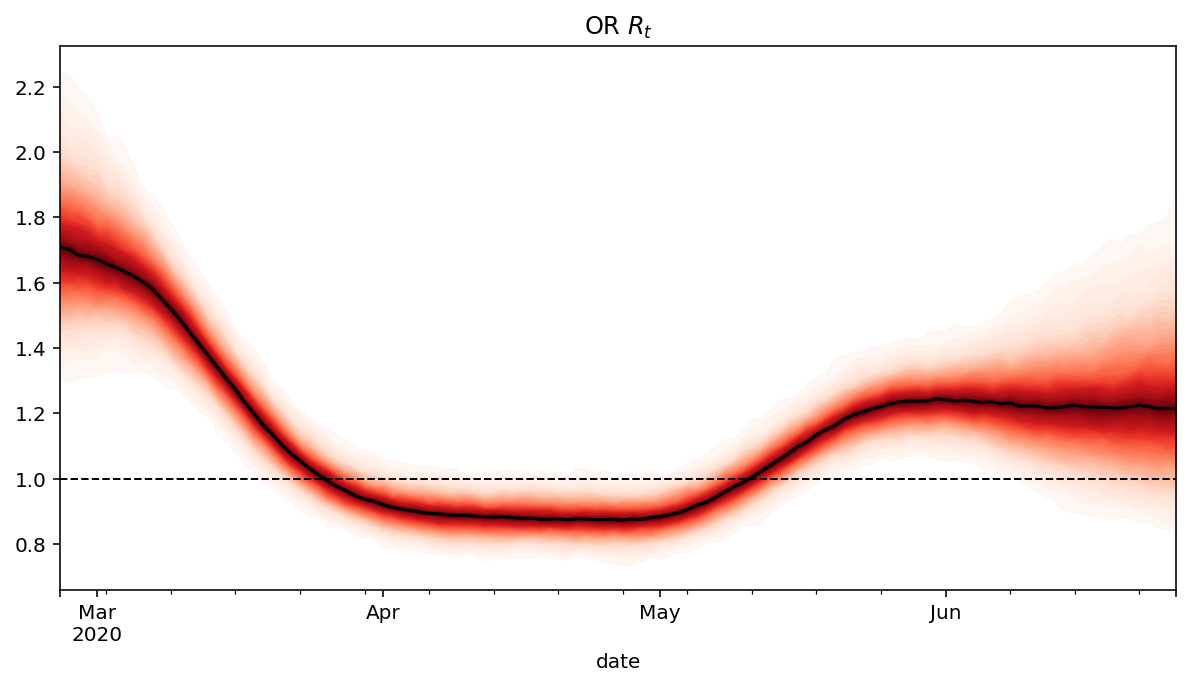

In [37]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')